In [369]:
#NECESSARY IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from sklearn.base import clone
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.preprocessing import *
from sklearn.impute import *
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import *
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import *
from sklearn.metrics import *

In [370]:
#IMPORT DATASET
df = pd.read_csv(r'C:\Users\shaur\Desktop\ML\Projects\FEC 5\credit_risk_dataset.csv')

<h1 style="font-size:30px; color:yellow; font-weight:bold;">DATA VISUALISATION</h1>

In [372]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [373]:
df.isnull().sum()  #CHECKING FOR NULL VALUES

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [374]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


<h1 style="font-size:30px; color:yellow; font-weight:bold;">DATA CLEANING</h1>

In [376]:
df['cb_person_default_on_file']= df['cb_person_default_on_file'].replace({'Y':1,'N':0}) #REPLACING YES-NO COLUMN WITH 0 AND 1

C:\Users\shaur\AppData\Local\Temp\ipykernel_4432\3258460254.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cb_person_default_on_file']= df['cb_person_default_on_file'].replace({'Y':1,'N':0}) #REPLACING YES-NO COLUMN WITH 0 AND 1


In [377]:
df.drop('loan_percent_income',axis=1,inplace=True)  #loan_percent_income = loan_amnt/person_income 
#so removing collinearity causing column

In [378]:
df.duplicated().value_counts()

False    32416
True       165
Name: count, dtype: int64

In [379]:
df.drop_duplicates(inplace=True) #removing duplicates

In [380]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,1,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0,26


<h1 style="font-size:30px; color:yellow; font-weight:bold;">EDA and DATA EXTRACTION<h1>

In [382]:
y=(df['loan_status']) #extracting output column

In [383]:
print("Class balance/imbalance?")
print("  0                 1")
print(100*np.unique(y,return_counts=True)[1]/np.unique(y,return_counts=True)[1].sum())
print(np.unique(y,return_counts=True)[1])

Class balance/imbalance?
  0                 1
[78.13116979 21.86883021]
[25327  7089]


In [384]:
X=pd.concat([df.iloc[:,:8],df.iloc[:,9:]],axis=1)  #extracting input column

In [385]:
X = X.loc[X['person_age']<100,:]  #taking records with age<100 so no absurd records are taken

In [386]:
X = X.loc[(X['person_emp_length']<85) | (X['person_emp_length'].isna()), :]  #similarly employment length should be <85 or na.

In [387]:
y = y[X.index]  #taking corresponding y values

In [388]:
X.shape,y.shape

((32409, 10), (32409,))

In [389]:
#value counts for categorical columns
print(X['loan_intent'].value_counts())
print("\n")
print(X['person_home_ownership'].value_counts())
print("\n")
print(X['loan_grade'].value_counts())
print("\n")
print(X['cb_person_default_on_file'].value_counts())

loan_intent
EDUCATION            6409
MEDICAL              6042
VENTURE              5679
PERSONAL             5496
DEBTCONSOLIDATION    5189
HOMEIMPROVEMENT      3594
Name: count, dtype: int64


person_home_ownership
RENT        16374
MORTGAGE    13366
OWN          2563
OTHER         106
Name: count, dtype: int64


loan_grade
A    10702
B    10384
C     6436
D     3619
E      963
F      241
G       64
Name: count, dtype: int64


cb_person_default_on_file
0    26680
1     5729
Name: count, dtype: int64


In [390]:
#statistics of numerical columns
X.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_default_on_file,cb_person_cred_hist_length
count,32409.000000,3.240900e+04,31522.000000,32409.000000,29315.000000,32409.000000,32409.000000
mean,27.730754,6.589428e+04,4.782850,9592.486655,11.017099,0.176772,5.811194
std,6.210445,5.251787e+04,4.037343,6320.885127,3.241718,0.381481,4.057899
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,4.000000
75%,30.000000,7.920000e+04,7.000000,12250.000000,13.470000,0.000000,8.000000
max,94.000000,2.039784e+06,41.000000,35000.000000,23.220000,1.000000,30.000000


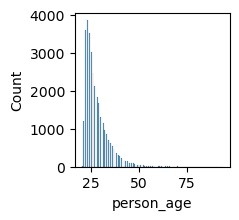

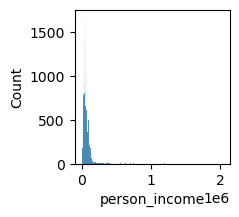

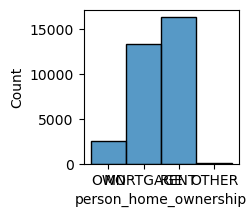

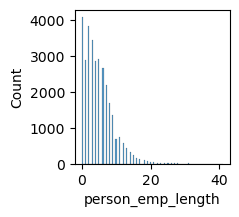

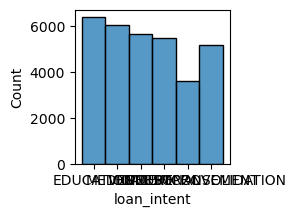

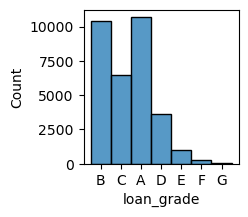

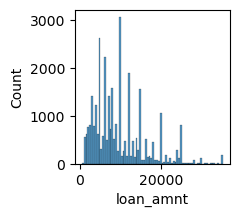

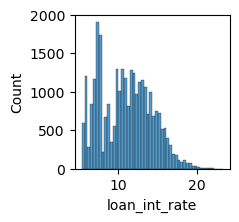

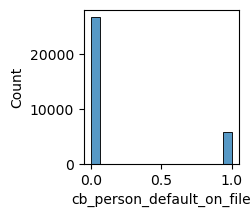

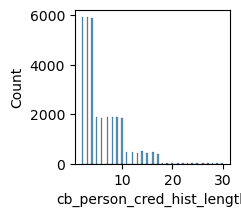

In [391]:
#distribution of numerical columns
for col in X.columns:
    plt.figure(figsize=(2,2))
    sns.histplot(X[col])
    plt.show()

<h1 style="font-size:30px; color:yellow; font-weight:bold;">DATA PREPROCESSING</h1>

In [393]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.25,random_state=42)

In [394]:
#checking if class distribution remains intact after split
np.unique(y_test,return_counts=True),np.unique(y_train,return_counts=True) 

((array([0, 1], dtype=int64), array([6339, 1764], dtype=int64)),
 (array([0, 1], dtype=int64), array([18982,  5324], dtype=int64)))

In [395]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((24306, 10), (8103, 10), (24306,), (8103,))

In [396]:
#APPLYING IMPUTATION AND SCALING ON NUMERICAL COLUMNS- num_transformer
#APPLYING ORDINAL ENCODING ON ORDINAL COLUMNS-cat_ord_transformer
#APPLYING ONE HOT ENCODING ON NOMINAL COLUMNS-cat_nom_transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
numeric_columns = ['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate',
                   'cb_person_cred_hist_length']
nominal_columns = ['person_home_ownership','loan_intent','cb_person_default_on_file',]
ordinal_columns = ['loan_grade']
num_transformer = Pipeline(steps = 
                               [('imp',SimpleImputer(strategy="mean")),
                                ('ss',StandardScaler())
                               ])
cat_ord_transformer = Pipeline(steps = [('oe',OrdinalEncoder(categories=[['G','F','E','D','C','B','A']]))])
cat_nom_transformer = Pipeline(steps = [('ohe',OneHotEncoder(sparse_output=False,drop='first'))])                         

transformer = ColumnTransformer(
    transformers=[('num',num_transformer,numeric_columns),
                  ('cat_o',cat_ord_transformer,ordinal_columns),
                  ('cat_n',cat_nom_transformer,nominal_columns)
                  ],
    remainder='passthrough')

In [397]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
#WE CAN ALSO USE THE PIPELINE LATER TO TRANSFORM WHOLE X

In [398]:
X_train.shape,X_test.shape,transformer.get_feature_names_out() #feature names for transformed data

((24306, 16),
 (8103, 16),
 array(['num__person_age', 'num__person_income', 'num__person_emp_length',
        'num__loan_amnt', 'num__loan_int_rate',
        'num__cb_person_cred_hist_length', 'cat_o__loan_grade',
        'cat_n__person_home_ownership_OTHER',
        'cat_n__person_home_ownership_OWN',
        'cat_n__person_home_ownership_RENT',
        'cat_n__loan_intent_EDUCATION',
        'cat_n__loan_intent_HOMEIMPROVEMENT', 'cat_n__loan_intent_MEDICAL',
        'cat_n__loan_intent_PERSONAL', 'cat_n__loan_intent_VENTURE',
        'cat_n__cb_person_default_on_file_1'], dtype=object))

In [399]:
feature_names =(transformer.get_feature_names_out())

In [400]:
full_data = transformer.transform(X)
data = pd.DataFrame(full_data,columns=feature_names)
labels = pd.DataFrame(y)
data

,num__person_age,num__person_income,num__person_emp_length,num__loan_amnt,num__loan_int_rate,num__cb_person_cred_hist_length,cat_o__loan_grade,cat_n__person_home_ownership_OTHER,cat_n__person_home_ownership_OWN,cat_n__person_home_ownership_RENT,cat_n__loan_intent_EDUCATION,cat_n__loan_intent_HOMEIMPROVEMENT,cat_n__loan_intent_MEDICAL,cat_n__loan_intent_PERSONAL,cat_n__loan_intent_VENTURE,cat_n__cb_person_default_on_file_1
0,-1.088435,-1.084009,0.057154,-1.359048,0.035014,-0.942190,5.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.441554,-1.084009,-0.946486,-0.646229,0.596697,-0.694540,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.764994,-0.002417,-0.193756,4.026693,1.362923,-0.942190,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.603274,-0.217187,0.809885,4.026693,1.051238,-0.446891,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-1.088435,-1.078204,-0.695576,-1.121441,-1.263675,-0.942190,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32404,4.733496,-0.244275,-0.946486,-0.598708,0.690852,5.991987,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32405,4.248335,1.052088,-0.193756,1.274421,-1.150040,3.267846,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32406,6.027259,0.200745,-0.444666,4.026693,-0.013687,5.496688,5.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
32407,4.571776,1.632549,0.057154,0.858610,0.145402,5.001390,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [401]:
X_train_df = pd.DataFrame(X_train,columns=transformer.get_feature_names_out())  #dataframe for xtrain, with column names
X_train_df

,num__person_age,num__person_income,num__person_emp_length,num__loan_amnt,num__loan_int_rate,num__cb_person_cred_hist_length,cat_o__loan_grade,cat_n__person_home_ownership_OTHER,cat_n__person_home_ownership_OWN,cat_n__person_home_ownership_RENT,cat_n__loan_intent_EDUCATION,cat_n__loan_intent_HOMEIMPROVEMENT,cat_n__loan_intent_MEDICAL,cat_n__loan_intent_PERSONAL,cat_n__loan_intent_VENTURE,cat_n__cb_person_default_on_file_1
0,-1.088435,-0.921480,-1.197397,-1.042239,-1.016924,-0.942190,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.367048,0.239442,-0.946486,2.601056,1.599934,-0.199242,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.603274,-1.077043,-0.193756,-1.327367,-1.214974,-0.446891,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.279834,-0.012091,-1.197397,-0.883835,-1.822111,-0.942190,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.118113,-0.186229,-0.193756,0.074510,-0.455241,0.543705,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24301,1.660810,-0.592552,0.057154,-0.725431,1.408377,2.029600,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
24302,-0.603274,-0.399065,0.809885,-0.725431,-1.701983,-0.694540,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
24303,-1.088435,-0.824736,0.308065,-1.042239,0.752539,-0.694540,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24304,-0.603274,0.262661,-0.444666,1.017014,0.531762,-0.942190,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


Axes(0.125,0.11;0.62x0.77)


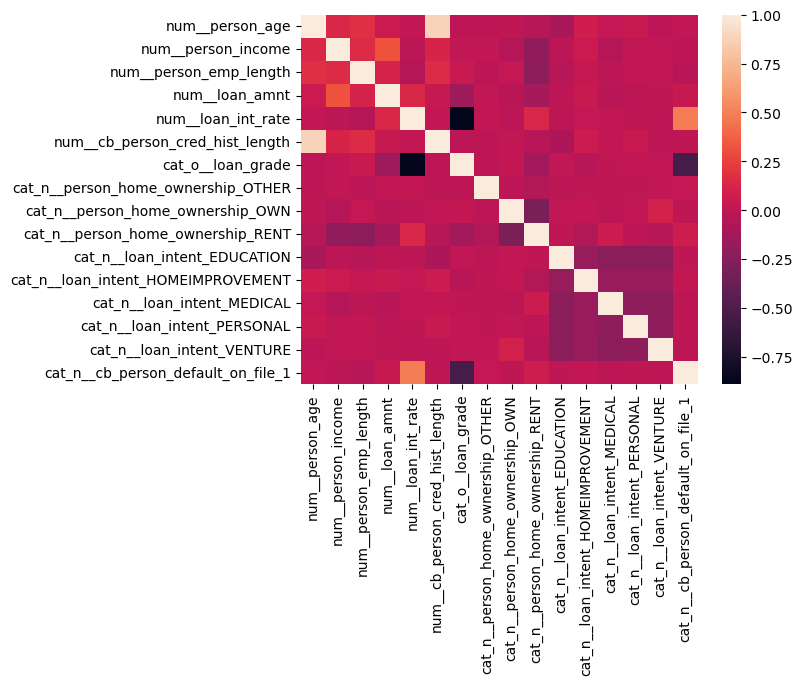

In [402]:
print(sns.heatmap(X_train_df.corr()))
     #features having high multicollineariy are not combined or removed to have better model interpretiability, and tree based models can handle it.

<h1 style="font-size:30px; color:yellow; font-weight:bold;">Preparting functions for evaluation</h1>

In [404]:
metrics = ['AUC','F1','Recall','Precision','Accuracy']
columns = ['model_name'] + metrics
results = pd.DataFrame(columns=columns)

<div style="border: 1px solid black; padding: 5px; background-color: white; color: black; font-size: 16px; font-weight: bold; text-align: left;">
📌 <em>For each model, we will hyperparameter tune it using stratified 5 fold cv on X_train. We will evaluate using X_test and y_test for following things:
1.Auc score
2.F1 score
3.precision
4.recall
5.auc-roc curve
6.feature importances if available.</em>

</div>

In [406]:
"""while preparing report of model, we will use this function to plot auc roc curve"""
def plot_roc_auc_curve(out,y_prob,name):
    fpr, tpr, thresholds = roc_curve(out, y_prob)  #fpr = false positive rate, tpr = true postive rate
    #fpr = fp/(fp+tn) and tpr = tp/(tp+fn)

    #find the point where tpr-fpr is maximised, i.e distance from (0,1) of fpr-tpr curve is minimised
    j_scores = tpr - fpr  
    best_idx = np.argmax(j_scores)
    best_threshold = thresholds[best_idx]

    # Plot ROC curve without label
    plt.figure(figsize=(3.5, 3.5))
    plt.plot(fpr, tpr, color='blue')  # No label
    plt.plot(fpr[best_idx], tpr[best_idx], 'ro', label=f'Best Threshold = {best_threshold:.2f}')
    plt.title(f"ROC Curve - {name}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(loc="lower right")  # Only shows the threshold
    plt.tight_layout()
    plt.show()

In [407]:
"""following function fits the model, calculates predicted  probabilities of defaulting (for auc score) as well as prediction in terms of 
0 and 1- and calculates accuracy,f1, precision,recall.
also print confusion matrix 
and plots the roc-auc curve, indicating the best threshold"""
def report(model,name=None):
    print("TEST RESULTS\n")
    model.fit(X_train ,y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
       y_prob = model.predict_proba(X_test)[:, 1]
    else:
       y_prob = model.decision_function(X_test)
    model_scores = {'AUC':roc_auc_score(y_test, y_prob),
                    'F1':f1_score(y_test,y_pred),
                    'Recall':recall_score(y_test,y_pred),
                    'Precision':precision_score(y_test,y_pred),
                    'Accuracy':accuracy_score(y_test,y_pred),
                    }
    y_train_pred = model.predict(X_train)
    update_and_print(name,model_scores)
    print(f"[Training accuracy: {accuracy_score(y_train,y_train_pred):.6f}]")
    tn,fp,fn,tp = (confusion_matrix(y_test,y_pred)).ravel()
    print("\n     0       1")
    print("0   ", tn, "  ", fp)
    print("1   ", fn, "  ", tp) 
    print("\n")
    plot_roc_auc_curve(out=y_test,y_prob=y_prob,name=name)

In [408]:
"""this function prints the 5 metrics and updates them in a dataframe, which contains these metrics for all the models which will be evaluated. this dataframe 
will be used for model comparison"""

def update_and_print(model_name,model_scores):
    for metric in model_scores:
        print(f"{metric} : {model_scores[metric]:.6f}")
        if model_name in results['model_name'].values:
            results.loc[results['model_name'] == model_name, metric] = model_scores[metric]
        else:
        # Create a new row with all attributes as NaN
            new_row = dict.fromkeys(results.columns, None)
            new_row['model_name'] = model_name
            new_row[metric] = model_scores[metric]
            results.loc[len(results)] = new_row
 

In [409]:
feature_importances_df = pd.DataFrame(columns=feature_names) ###initialising feature importances dataset

In [410]:
"""we will this function, for tree based and linear models because they have inherent calculations of feature importances- they have methods that return 
these importances in an array. so we will call this function later and plot a barplot containing all features and their corresponding importance for each
model, by passing in the array of feature importances from the model. the importances will be similarly stored in a seperate dataframe for all models"""
def plot_feature_importances(feature_scores, model_name):
    # Convert scores to Series with feature names
    importances_series = pd.Series(feature_scores, index=feature_names)
    sorted_importances = importances_series.sort_values()

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
    plt.title(f"Feature Impact on Risk: {model_name}")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

    # Update the global DataFrame
    feature_importances_df.loc[model_name] = importances_series.values

<h1 style="font-size:30px; color:yellow; font-weight:bold;">Evaluating Different Models</h1>

<div style="border: 1px solid black; padding: 5px; background-color: white; color: black; font-size: 16px; font-weight: bold; text-align: left;">
📌 <em>For each model, if hyperparameter tuning is done, the huge cell with commented red code is hyperparamter tuning code which takes time and has already been done and best model has been found. We dont need to run the cell again hence it is commented out. The model is fed in the best parameters from the tuning process and report function and plot_feature_importance function is used to evaluate.
Note:Tuning is done on AUC score as it covers all thresholds</em>

</div>

<h1 style="font-size:30px; color:cyan; font-weight:bold;">Gaussian Naive Bayes</h1>

TEST RESULTS

AUC : 0.782699
F1 : 0.519031
Recall : 0.552721
Precision : 0.489212
Accuracy : 0.776996
[Training accuracy: 0.775776]

     0       1
0    5321    1018
1    789    975




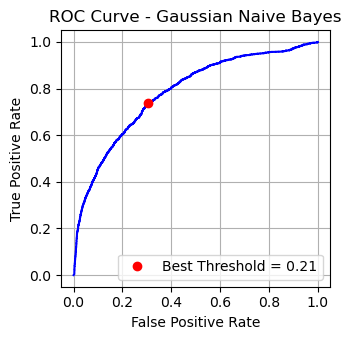

In [414]:
nb = GaussianNB()
report(nb,"Gaussian Naive Bayes")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">LOGISTIC REGRESSION</h1>

TEST RESULTS

AUC : 0.843405
F1 : 0.570956
Recall : 0.489229
Precision : 0.685465
Accuracy : 0.839936
[Training accuracy: 0.846417]

     0       1
0    5943    396
1    901    863




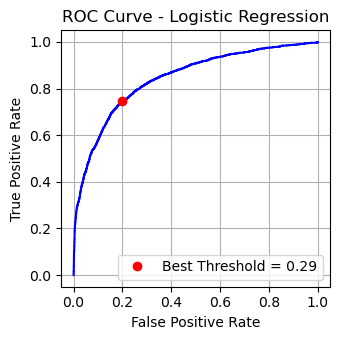

In [416]:
lr = LogisticRegression(C=0.1, intercept_scaling=1.0, max_iter=800,
                   penalty='l2', random_state=42, solver='saga',
                   tol=0.0002,class_weight={0:5,1:6})
report(lr,name="Logistic Regression")


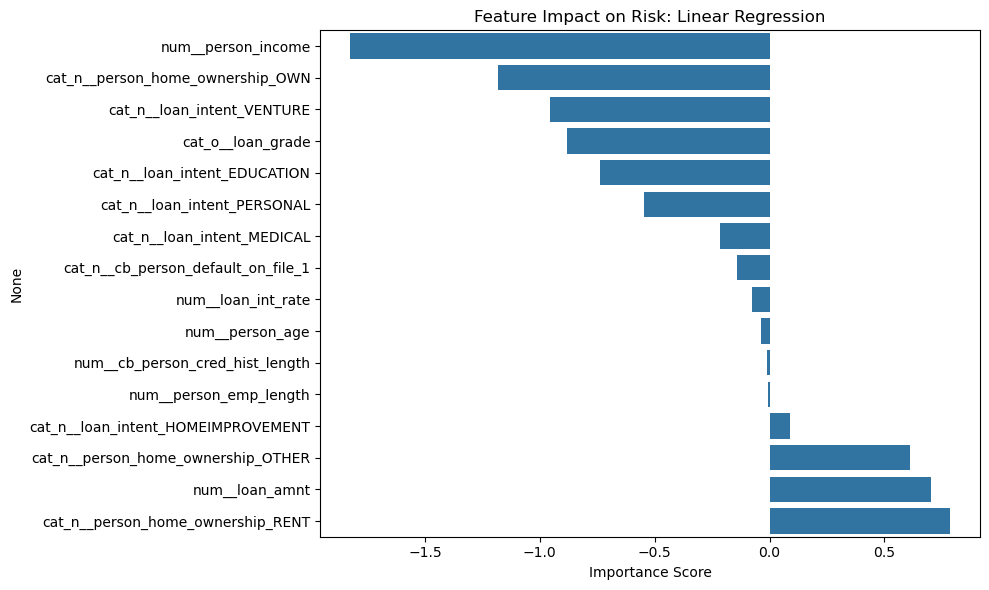

In [417]:
plot_feature_importances(lr.coef_[0],"Linear Regression")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">SVC</h1>

TEST RESULTS

AUC : 0.842808
F1 : 0.517586
Recall : 0.396259
Precision : 0.745998
Accuracy : 0.839195
[Training accuracy: 0.845553]

     0       1
0    6101    238
1    1065    699




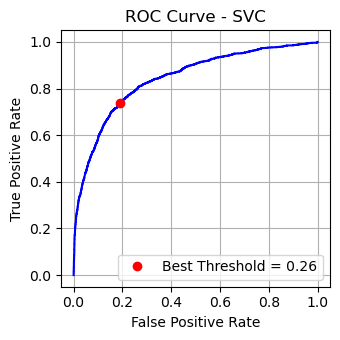

In [419]:
#takes 1.5 minutes
svc = SVC(kernel='linear',probability=True)
report(svc,name="SVC")

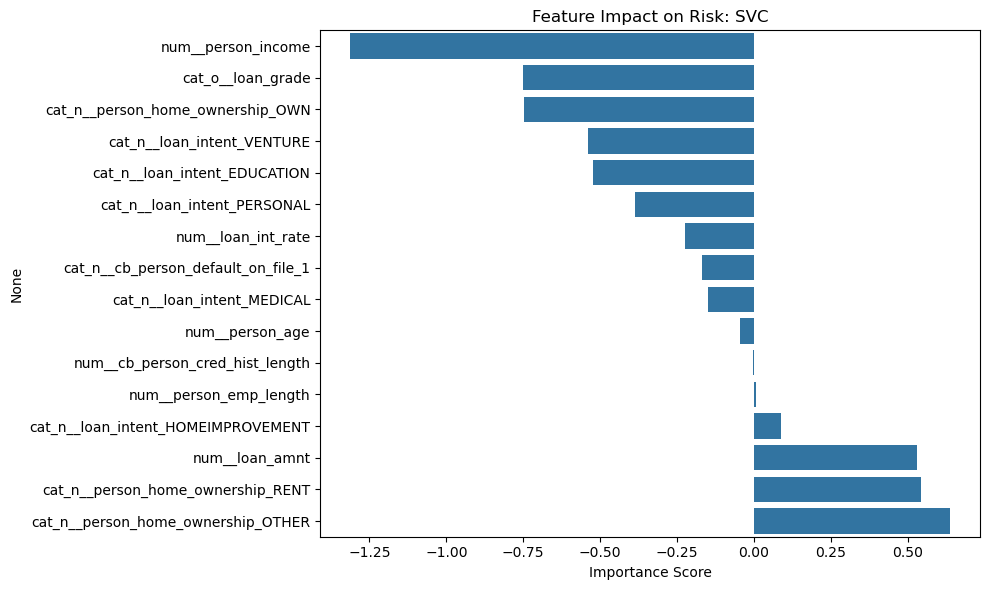

In [420]:
plot_feature_importances(svc.coef_[0],"SVC")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">AdaBoost</h1>

In [422]:
"""
def objective(trial):
    # Choose base estimator type
    base_estimator_name = trial.suggest_categorical("base_estimator", ["decision_tree", "logistic"])

    if base_estimator_name == "decision_tree":
        max_depth = trial.suggest_int("dt_max_depth", 1, 10)
        min_samples_split = trial.suggest_int("dt_min_samples_split", 2, 20)
        min_samples_leaf = trial.suggest_int("dt_min_samples_leaf", 1, 20)
        criterion = trial.suggest_categorical("dt_criterion", ["gini", "entropy", "log_loss"])
        base_estimator = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            criterion=criterion
        )
    elif base_estimator_name == "logistic":
        C = trial.suggest_float("lr_C", 0.001, 10.0, log=True)
        penalty = trial.suggest_categorical("lr_penalty", ["l2", "l1"])
        solver = "liblinear" if penalty == "l1" else "lbfgs"
        base_estimator = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=500)


    # AdaBoost hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 2.0, log=True)
    algorithm = trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])

    # Create model
    model = AdaBoostClassifier(
        base_estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        algorithm=algorithm,
        random_state=42
    )

    # Sample weights to handle class imbalance (0:79%, 1:21%)
    sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

    # Stratified 5-fold CV
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=skf, fit_params={'sample_weight': sample_weight})

    return np.mean(scores)

# Run Optuna Study
study = optuna.create_study(direction="maximize", study_name="adaboost_auc")
study.optimize(objective, n_trials=30, n_jobs=-1, show_progress_bar=True)


# Rebuild best base_estimator
if best_params["base_estimator"] == "decision_tree":
    base_estimator = DecisionTreeClassifier(
        max_depth=best_params["dt_max_depth"],
        min_samples_split=best_params["dt_min_samples_split"],
        min_samples_leaf=best_params["dt_min_samples_leaf"],
        criterion=best_params["dt_criterion"]
    )
elif best_params["base_estimator"] == "logistic":
    solver = "liblinear" if best_params["lr_penalty"] == "l1" else "lbfgs"
    base_estimator = LogisticRegression(
        C=best_params["lr_C"],
        penalty=best_params["lr_penalty"],
        solver=solver,
        max_iter=500
    )
print(study.best_trial.params)
"""

'\ndef objective(trial):\n    # Choose base estimator type\n    base_estimator_name = trial.suggest_categorical("base_estimator", ["decision_tree", "logistic"])\n\n    if base_estimator_name == "decision_tree":\n        max_depth = trial.suggest_int("dt_max_depth", 1, 10)\n        min_samples_split = trial.suggest_int("dt_min_samples_split", 2, 20)\n        min_samples_leaf = trial.suggest_int("dt_min_samples_leaf", 1, 20)\n        criterion = trial.suggest_categorical("dt_criterion", ["gini", "entropy", "log_loss"])\n        base_estimator = DecisionTreeClassifier(\n            max_depth=max_depth,\n            min_samples_split=min_samples_split,\n            min_samples_leaf=min_samples_leaf,\n            criterion=criterion\n        )\n    elif base_estimator_name == "logistic":\n        C = trial.suggest_float("lr_C", 0.001, 10.0, log=True)\n        penalty = trial.suggest_categorical("lr_penalty", ["l2", "l1"])\n        solver = "liblinear" if penalty == "l1" else "lbfgs"\n      

TEST RESULTS

AUC : 0.941156
F1 : 0.819308
Recall : 0.731293
Precision : 0.931408
Accuracy : 0.929779
[Training accuracy: 0.939850]

     0       1
0    6244    95
1    474    1290




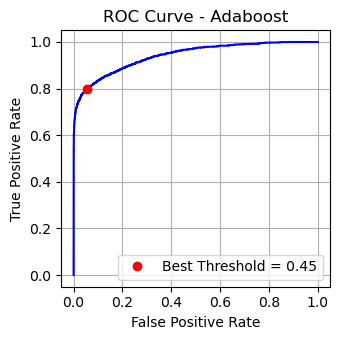

In [423]:
weak_learner = DecisionTreeClassifier(max_depth=8,min_samples_split=10,min_samples_leaf=11,max_features=None,criterion='entropy')
adbc = AdaBoostClassifier(estimator=weak_learner, n_estimators=223, learning_rate=0.34768790721882703, random_state=42)
report(adbc,name="Adaboost")

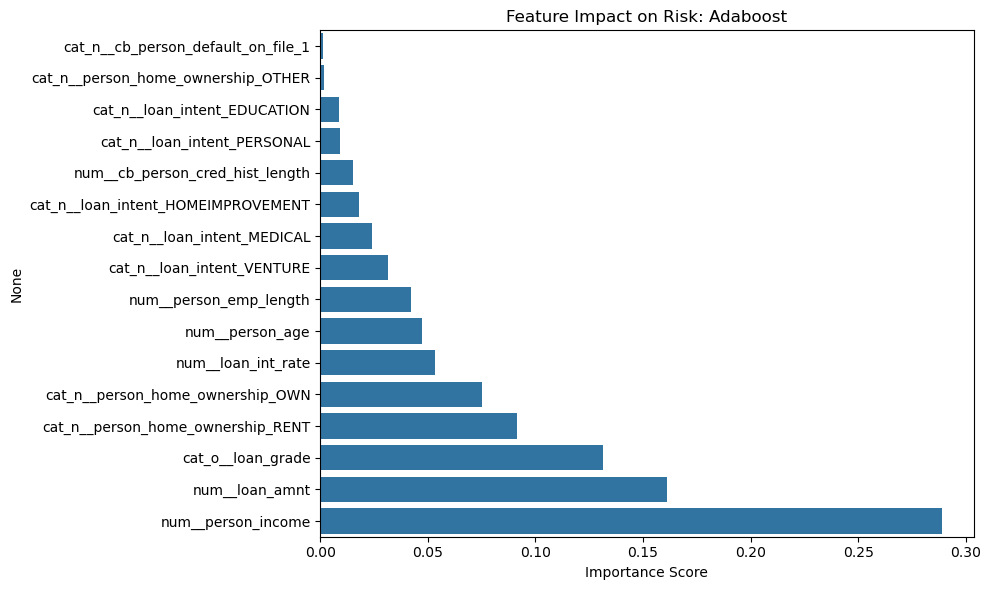

In [424]:
plot_feature_importances(adbc.feature_importances_,"Adaboost")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">KNN</h1>

In [426]:
"""
def objective(trial):
    # Suggest hyperparameters
    n_neighbors = trial.suggest_int("n_neighbors", 1, 50)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    algorithm = trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])
    leaf_size = trial.suggest_int("leaf_size", 10, 100)
    p = trial.suggest_int("p", 1, 2)  # 1=manhattan, 2=euclidean
    metric = trial.suggest_categorical("metric", ["minkowski", "euclidean", "manhattan", "chebyshev"])

    # Define model
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p,
        metric=metric
    )

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validated AUC
    auc_scores = cross_val_score(model, X_train, y_train, 
                                  cv=skf, 
                                  scoring="roc_auc",
                                  n_jobs=-1)
    return np.mean(auc_scores)

# Create study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=-1) 
print(study.best_trial.params)
print("Best AUC Score:", study.best_value)
""" 

'\ndef objective(trial):\n    # Suggest hyperparameters\n    n_neighbors = trial.suggest_int("n_neighbors", 1, 50)\n    weights = trial.suggest_categorical("weights", ["uniform", "distance"])\n    algorithm = trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])\n    leaf_size = trial.suggest_int("leaf_size", 10, 100)\n    p = trial.suggest_int("p", 1, 2)  # 1=manhattan, 2=euclidean\n    metric = trial.suggest_categorical("metric", ["minkowski", "euclidean", "manhattan", "chebyshev"])\n\n    # Define model\n    model = KNeighborsClassifier(\n        n_neighbors=n_neighbors,\n        weights=weights,\n        algorithm=algorithm,\n        leaf_size=leaf_size,\n        p=p,\n        metric=metric\n    )\n\n    # Stratified K-Fold Cross-Validation\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n    # Cross-validated AUC\n    auc_scores = cross_val_score(model, X_train, y_train, \n                                  cv=skf, \n             

TEST RESULTS

AUC : 0.880649
F1 : 0.601717
Recall : 0.456916
Precision : 0.880874
Accuracy : 0.868320
[Training accuracy: 1.000000]

     0       1
0    6230    109
1    958    806




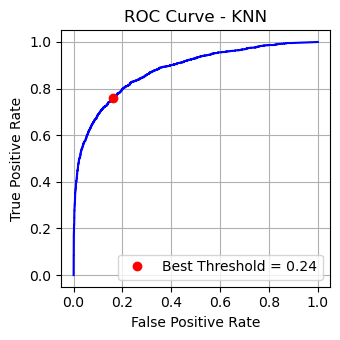

In [427]:
knn = KNeighborsClassifier(n_neighbors=39,weights='distance',algorithm='auto',leaf_size=87,p=1,metric='minkowski')
report(knn, name="KNN") ##overfit is high

<h1 style="font-size:30px; color:cyan; font-weight:bold;">Decision Tree</h1>

In [429]:
"""
def objective(trial):
    # Suggest hyperparameters
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    splitter = trial.suggest_categorical("splitter", ["best", "random"])
    max_depth = trial.suggest_int("max_depth", 1, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2"])
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    # Model
    model = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=class_weight,
        random_state=42
    )

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc = cross_val_score(model, X_train, y_train, 
                          cv=skf, 
                          scoring="roc_auc", 
                          n_jobs=-1)
    return np.mean(auc)

# Create and run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=-1)

# Output best params
print("Best AUC Score:", study.best_value)
print("Best Params:", study.best_params)"""


'\ndef objective(trial):\n    # Suggest hyperparameters\n    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])\n    splitter = trial.suggest_categorical("splitter", ["best", "random"])\n    max_depth = trial.suggest_int("max_depth", 1, 50)\n    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)\n    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)\n    max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2"])\n    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])\n\n    # Model\n    model = DecisionTreeClassifier(\n        criterion=criterion,\n        splitter=splitter,\n        max_depth=max_depth,\n        min_samples_split=min_samples_split,\n        min_samples_leaf=min_samples_leaf,\n        max_features=max_features,\n        class_weight=class_weight,\n        random_state=42\n    )\n\n    # Cross-validation\n    skf = StratifiedKFold(n_splits=5, shuffle=True, rando

TEST RESULTS

AUC : 0.903693
F1 : 0.751973
Recall : 0.756236
Precision : 0.747758
Accuracy : 0.891398
[Training accuracy: 0.902699]

     0       1
0    5889    450
1    430    1334




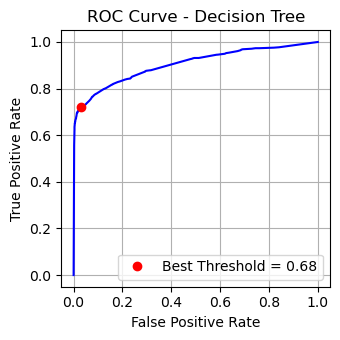

In [430]:
dt = DecisionTreeClassifier(max_depth=9,criterion='gini',splitter='best',min_samples_split=15,min_samples_leaf=6,max_features=None,class_weight='balanced')
report(dt,name="Decision Tree")

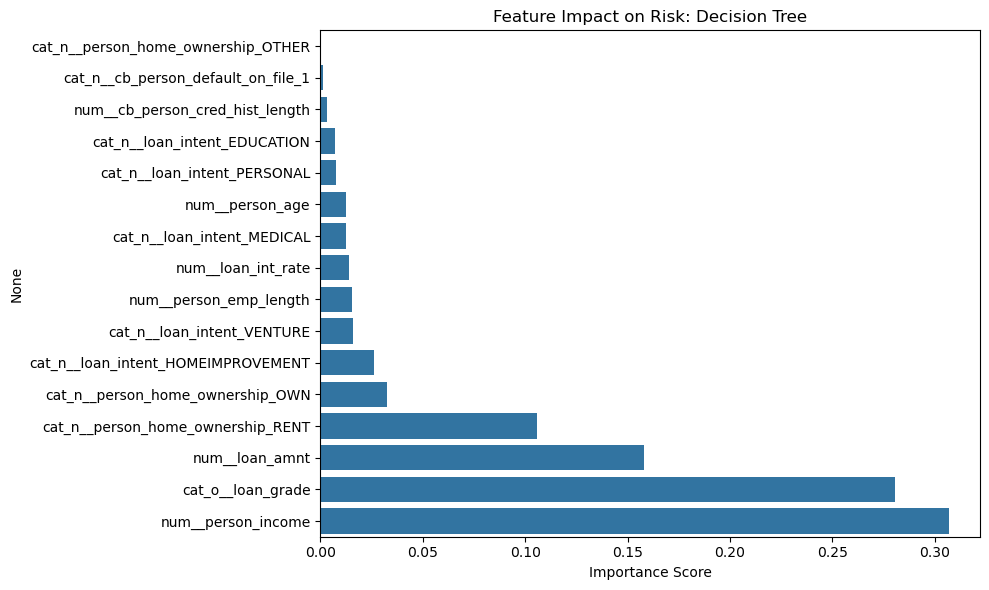

In [431]:
plot_feature_importances(dt.feature_importances_,"Decision Tree")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">Gradient Boosting</h1>

In [433]:
"""
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 100),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.05),
        "tol": trial.suggest_float("tol", 1e-5, 1e-1, log=True),
        "validation_fraction": trial.suggest_float("validation_fraction", 0.1, 0.4),
        "n_iter_no_change": trial.suggest_int("n_iter_no_change", 5, 20)
    }

    auc_scores = []
    accuracy_diff_ok = True
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = GradientBoostingClassifier(**params)
        model.fit(X_tr, y_tr)

        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_tr)

        auc = roc_auc_score(y_val, y_val_pred_proba)
        auc_scores.append(auc)

        train_acc = accuracy_score(y_tr, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        if train_acc - val_acc > 0.014:
           accuracy_diff_ok = False
           break

   return np.mean(auc_scores) if accuracy_diff_ok else 0.0

 #Optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, n_jobs=-1)

 #Output best results
print("Best AUC score:", study.best_value)
print("Best hyperparameters:")
print(study.best_params)"""


'\ndef objective(trial):\n    params = {\n        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),\n        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2, log=True),\n        "max_depth": trial.suggest_int("max_depth", 2, 10),\n        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),\n        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),\n        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),\n        "subsample": trial.suggest_float("subsample", 0.5, 1.0),\n        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 100),\n        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.05),\n        "tol": trial.suggest_float("tol", 1e-5, 1e-1, log=True),\n        "validation_fraction": trial.suggest_float("validation_fraction", 0.1, 0.4),\n        "n_iter_no_change": trial.suggest_int("n_iter_no_change", 5, 20)\n    }\n\n    auc_scores = []\n    accuracy_diff_ok = True\n    s

TEST RESULTS

AUC : 0.926805
F1 : 0.808960
Recall : 0.716553
Precision : 0.928729
Accuracy : 0.926324
[Training accuracy: 0.928207]

     0       1
0    6242    97
1    500    1264




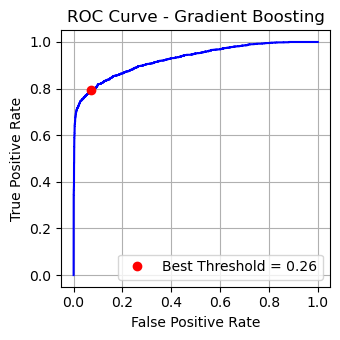

In [434]:
gb = GradientBoostingClassifier(n_estimators= 296,  learning_rate= 0.07100831044544345,max_depth= 10, min_samples_split= 8, min_samples_leaf= 9, 
                                subsample= 0.9807219005969581, max_features= 'log2', max_leaf_nodes= 31, ccp_alpha=6.368507328808958e-05, 
                                tol= 0.0006173992022594928, validation_fraction= 0.21889975953196425, n_iter_no_change= 13)
report(gb,name="Gradient Boosting")

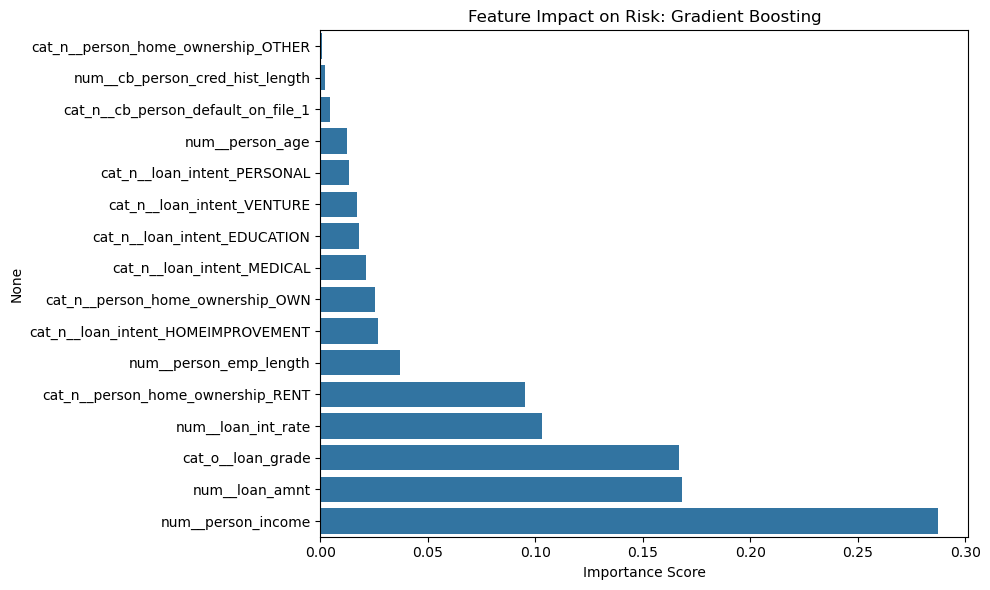

In [435]:
plot_feature_importances(gb.feature_importances_,"Gradient Boosting")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">Bagging</h1>

In [437]:
"""def objective(trial):
    # Define base estimator hyperparameters (e.g., decision tree)
    base_estimator = DecisionTreeClassifier(
        max_depth=trial.suggest_int("max_depth", 1, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),
        max_features=trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    )

    # BaggingClassifier hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 300),
        "max_samples": trial.suggest_float("max_samples", 0.5, 1.0),
        "max_features": trial.suggest_float("bagging_max_features", 0.5, 1.0),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "bootstrap_features": trial.suggest_categorical("bootstrap_features", [True, False]),
        "estimator": base_estimator,
        "n_jobs": -1,
        "random_state": 42
    }

    auc_scores = []
    accuracy_diff_ok = True
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = BaggingClassifier(**params)
        model.fit(X_tr, y_tr)

        y_val_proba = model.predict_proba(X_val)[:, 1]
        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_tr)

        auc = roc_auc_score(y_val, y_val_proba)
        auc_scores.append(auc)

        train_acc = accuracy_score(y_tr, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        if train_acc - val_acc > 0.012:
            accuracy_diff_ok = False
            break

    return np.mean(auc_scores) if accuracy_diff_ok else 0.0

# Run Optuna with parallel trial evaluation
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Output best result
print("Best AUC score:", study.best_value)
print("Best hyperparameters:")
print(study.best_params)"""


'def objective(trial):\n    # Define base estimator hyperparameters (e.g., decision tree)\n    base_estimator = DecisionTreeClassifier(\n        max_depth=trial.suggest_int("max_depth", 1, 20),\n        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),\n        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),\n        max_features=trial.suggest_categorical("max_features", ["sqrt", "log2", None])\n    )\n\n    # BaggingClassifier hyperparameters\n    params = {\n        "n_estimators": trial.suggest_int("n_estimators", 10, 300),\n        "max_samples": trial.suggest_float("max_samples", 0.5, 1.0),\n        "max_features": trial.suggest_float("bagging_max_features", 0.5, 1.0),\n        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),\n        "bootstrap_features": trial.suggest_categorical("bootstrap_features", [True, False]),\n        "estimator": base_estimator,\n        "n_jobs": -1,\n        "random_state": 42\n    }\n\n    auc_scores =

TEST RESULTS

AUC : 0.902824
F1 : 0.514519
Recall : 0.356576
Precision : 0.923642
Accuracy : 0.853511
[Training accuracy: 0.859212]

     0       1
0    6287    52
1    1135    629




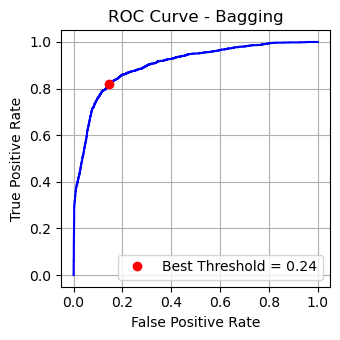

In [438]:
base_clf = DecisionTreeClassifier(max_depth=14, random_state=42,max_features='sqrt',min_samples_leaf= 13,min_samples_split= 9)
bag = BaggingClassifier(estimator=base_clf, n_estimators=90, max_samples=0.7942303259617921,max_features=0.6970175763082983, 
                                bootstrap_features=True,random_state=42,bootstrap=True)
report(bag,name="Bagging")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">Voting</h1>

In [440]:
"""def objective(trial):
    # XGBoost
    xgb = XGBClassifier(
        n_estimators=trial.suggest_int("xgb_n_estimators", 50, 300),
        max_depth=trial.suggest_int("xgb_max_depth", 3, 10),
        learning_rate=trial.suggest_float("xgb_learning_rate", 0.01, 0.3, log=True),
        subsample=trial.suggest_float("xgb_subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("xgb_colsample_bytree", 0.6, 1.0),
        use_label_encoder=False,
        eval_metric="logloss",
        n_jobs=-1,
        verbosity=0
    )

    # LightGBM
    lgbm = LGBMClassifier(
        n_estimators=trial.suggest_int("lgb_n_estimators", 50, 300),
        max_depth=trial.suggest_int("lgb_max_depth", 3, 10),
        learning_rate=trial.suggest_float("lgb_learning_rate", 0.01, 0.3, log=True),
        subsample=trial.suggest_float("lgb_subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("lgb_colsample_bytree", 0.6, 1.0),
        n_jobs=-1
    )

    # Gradient Boosting (Sklearn)
    gbdt = GradientBoostingClassifier(
        n_estimators=trial.suggest_int("gbdt_n_estimators", 50, 300),
        max_depth=trial.suggest_int("gbdt_max_depth", 3, 10),
        learning_rate=trial.suggest_float("gbdt_learning_rate", 0.01, 0.3, log=True),
        subsample=trial.suggest_float("gbdt_subsample", 0.6, 1.0),
        max_features=trial.suggest_categorical("gbdt_max_features", ["sqrt", "log2", None])
    )

    # Voting ensemble
    ensemble = VotingClassifier(
        estimators=[("xgb", xgb), ("lgbm", lgbm), ("gbdt", gbdt)],
        voting="soft",
        n_jobs=-1
    )

    auc_scores = []
    accuracy_diff_ok = True
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = clone(ensemble)
        model.fit(X_tr, y_tr)

        y_val_proba = model.predict_proba(X_val)[:, 1]
        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_tr)

        auc = roc_auc_score(y_val, y_val_proba)
        auc_scores.append(auc)

        train_acc = accuracy_score(y_tr, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        if train_acc - val_acc > 0.012:
            accuracy_diff_ok = False
            break

    return np.mean(auc_scores) if accuracy_diff_ok else 0.0

# Run the Optuna search
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=-1)

# Show results
print("Best AUC:", study.best_value)
print("Best Parameters:")
print(study.best_params)"""


'def objective(trial):\n    # XGBoost\n    xgb = XGBClassifier(\n        n_estimators=trial.suggest_int("xgb_n_estimators", 50, 300),\n        max_depth=trial.suggest_int("xgb_max_depth", 3, 10),\n        learning_rate=trial.suggest_float("xgb_learning_rate", 0.01, 0.3, log=True),\n        subsample=trial.suggest_float("xgb_subsample", 0.6, 1.0),\n        colsample_bytree=trial.suggest_float("xgb_colsample_bytree", 0.6, 1.0),\n        use_label_encoder=False,\n        eval_metric="logloss",\n        n_jobs=-1,\n        verbosity=0\n    )\n\n    # LightGBM\n    lgbm = LGBMClassifier(\n        n_estimators=trial.suggest_int("lgb_n_estimators", 50, 300),\n        max_depth=trial.suggest_int("lgb_max_depth", 3, 10),\n        learning_rate=trial.suggest_float("lgb_learning_rate", 0.01, 0.3, log=True),\n        subsample=trial.suggest_float("lgb_subsample", 0.6, 1.0),\n        colsample_bytree=trial.suggest_float("lgb_colsample_bytree", 0.6, 1.0),\n        n_jobs=-1\n    )\n\n    # Gradient 

TEST RESULTS



C:\Users\shaur\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\shaur\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\shaur\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC : 0.930215
F1 : 0.806598
Recall : 0.706916
Precision : 0.939006
Accuracy : 0.926200
[Training accuracy: 0.927261]

     0       1
0    6258    81
1    517    1247




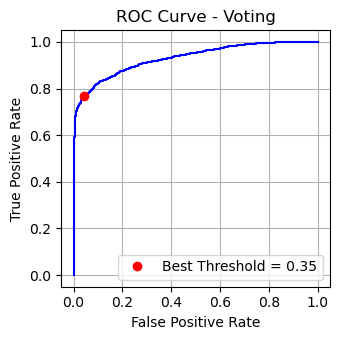

In [441]:
clf1 = LGBMClassifier(n_estimators=130,max_depth=9,subsample=0.04951879195135503,colsample_bytree=0.6714201289555313,learning_rate=0.04951879195135503)
clf2 = XGBClassifier(n_estimators=179,max_depth=4,learning_rate=0.03787450478965768,subsample=0.608991831926086,colsample_bytree=0.7147861864193918)
clf3 = GradientBoostingClassifier(n_estimators=297,max_depth=3,learning_rate=0.020299345009602836,subsample=0.9048300259419569)  
voting_clf_soft = VotingClassifier(estimators=[('lgbm', clf1), ('xgb', clf2), ('gb', clf3)],voting='soft')
report(voting_clf_soft,name="Voting")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">Random Forest</h1>

In [443]:
"""def objective(trial):
    m = RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        max_depth=trial.suggest_int("max_depth", 3, 30),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),
        max_features=trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        bootstrap=trial.suggest_categorical("bootstrap", [True, False]),
        criterion=trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        n_jobs=-1,
        random_state=42
    )

    auc_scores = []
    accuracy_diff_ok = True
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = clone(rf)
        model.fit(X_tr, y_tr)

        y_val_proba = model.predict_proba(X_val)[:, 1]
        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_tr)

        auc = roc_auc_score(y_val, y_val_proba)
        auc_scores.append(auc)

        train_acc = accuracy_score(y_tr, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        if train_acc - val_acc > 0.012:
            accuracy_diff_ok = False
            break

    return np.mean(auc_scores) if accuracy_diff_ok else 0.0

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=-1)

# Output best results
print("Best AUC:", study.best_value)
print("Best parameters:")
print(study.best_params)
"""

'def objective(trial):\n    rf = RandomForestClassifier(\n        n_estimators=trial.suggest_int("n_estimators", 100, 500),\n        max_depth=trial.suggest_int("max_depth", 3, 30),\n        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),\n        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),\n        max_features=trial.suggest_categorical("max_features", ["sqrt", "log2", None]),\n        bootstrap=trial.suggest_categorical("bootstrap", [True, False]),\n        criterion=trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),\n        n_jobs=-1,\n        random_state=42\n    )\n\n    auc_scores = []\n    accuracy_diff_ok = True\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n    for train_idx, val_idx in skf.split(X_train, y_train):\n        X_tr, X_val = X_train[train_idx], X_train[val_idx]\n        y_tr, y_val = y_train[train_idx], y_train[val_idx]\n\n        model = clone(rf)\n        model.fit(X_tr, y_tr)\n

TEST RESULTS

AUC : 0.934175
F1 : 0.807856
Recall : 0.699546
Precision : 0.955848
Accuracy : 0.927558
[Training accuracy: 0.929894]

     0       1
0    6282    57
1    530    1234




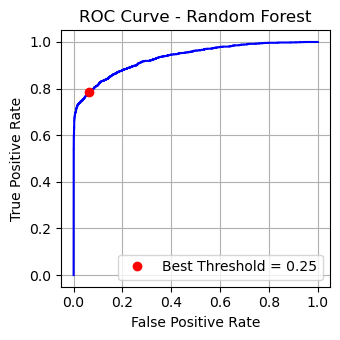

In [444]:
rf = RandomForestClassifier(n_estimators=294,min_samples_split=10,min_samples_leaf=15,
                            max_features=None,bootstrap=True,random_state=42,max_depth=17,criterion='log_loss',n_jobs=-1)
report(rf,name="Random Forest")

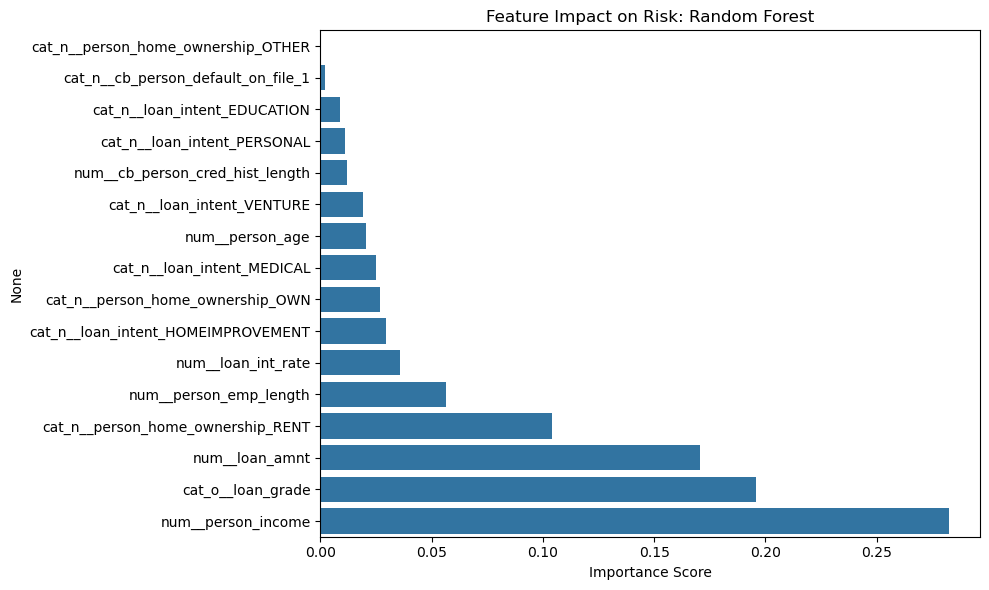

In [445]:
plot_feature_importances(rf.feature_importances_,"Random Forest")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">XGBoost</h1>

In [447]:
"""def objective(trial):
    model = XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 600),
        max_depth=trial.suggest_int("max_depth", 3, 25),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        gamma=trial.suggest_float("gamma", 0, 10),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 5.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        use_label_encoder=False,
        eval_metric="logloss",
        n_jobs=-1,
        verbosity=0,
        random_state=42
    )

    auc_scores = []
    accuracy_diff_ok = True
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        clf = clone(model)
        clf.fit(X_tr, y_tr)

        y_val_proba = clf.predict_proba(X_val)[:, 1]
        y_val_pred = clf.predict(X_val)
        y_train_pred = clf.predict(X_tr)

        auc = roc_auc_score(y_val, y_val_proba)
        auc_scores.append(auc)

        train_acc = accuracy_score(y_tr, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        if train_acc - val_acc > 0.012:
            accuracy_diff_ok = False
            break

    return np.mean(auc_scores) if accuracy_diff_ok else 0.0

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

# Show best results
print("Best AUC:", study.best_value)
print("Best parameters:")
print(study.best_params)"""

'def objective(trial):\n    model = XGBClassifier(\n        n_estimators=trial.suggest_int("n_estimators", 100, 600),\n        max_depth=trial.suggest_int("max_depth", 3, 25),\n        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),\n        subsample=trial.suggest_float("subsample", 0.6, 1.0),\n        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),\n        gamma=trial.suggest_float("gamma", 0, 10),\n        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 5.0),\n        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),\n        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),\n        use_label_encoder=False,\n        eval_metric="logloss",\n        n_jobs=-1,\n        verbosity=0,\n        random_state=42\n    )\n\n    auc_scores = []\n    accuracy_diff_ok = True\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n    for train_idx, val_idx in skf.split(X_train, y_train):\n        X_tr, X_val = X_t

TEST RESULTS

AUC : 0.943860
F1 : 0.835726
Recall : 0.742630
Precision : 0.955507
Accuracy : 0.936443
[Training accuracy: 0.938246]

     0       1
0    6278    61
1    454    1310




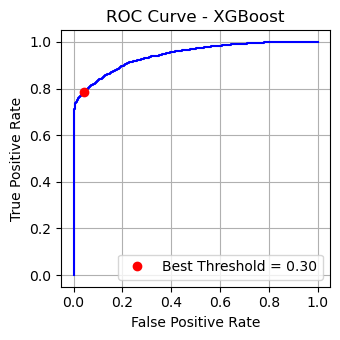

In [448]:
xgbc = XGBClassifier(
        n_estimators=560,
        max_depth=21,
        learning_rate=0.019264059970508885,
        subsample=0.9099872547210227,
        colsample_bytree=0.9099872547210227,
        gamma=1.6832988970579357,
        reg_alpha=1.8580562518252144,
        reg_lambda=2.374018122639157,
        min_child_weight=3,
        use_label_encoder=False,
        eval_metric="logloss",
        n_jobs=-1,
        verbosity=0,
        random_state=42
    )
report(xgbc,name="XGBoost")

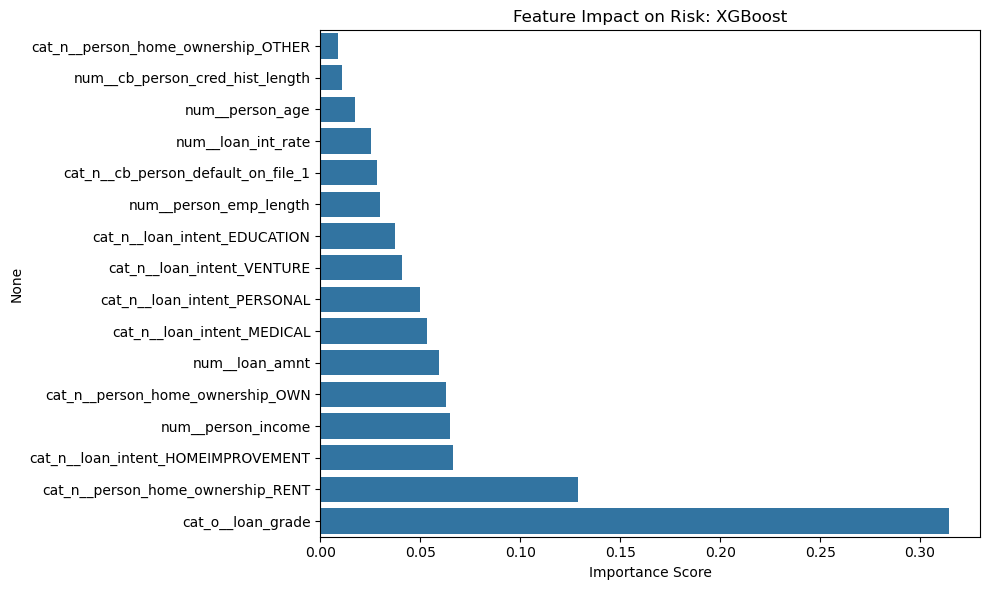

In [449]:
plot_feature_importances(xgbc.feature_importances_,"XGBoost")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">LightBGM</h1>

In [451]:
"""def objective(trial):
    model = LGBMClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        max_depth=trial.suggest_int("max_depth", 3, 25),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        num_leaves=trial.suggest_int("num_leaves", 7, 255),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 100),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 5.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        n_jobs=-1,
        random_state=42
    )

    auc_scores = []
    accuracy_diff_ok = True
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        clf = clone(model)
        clf.fit(X_tr, y_tr)

        y_val_proba = clf.predict_proba(X_val)[:, 1]
        y_val_pred = clf.predict(X_val)
        y_train_pred = clf.predict(X_tr)

        auc = roc_auc_score(y_val, y_val_proba)
        auc_scores.append(auc)

        train_acc = accuracy_score(y_tr, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        if train_acc - val_acc > 0.012:
            accuracy_diff_ok = False
            break

    return np.mean(auc_scores) if accuracy_diff_ok else 0.0

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=-1)

# Output best results
print("Best AUC:", study.best_value)
print("Best parameters:")
print(study.best_params)"""


'def objective(trial):\n    model = LGBMClassifier(\n        n_estimators=trial.suggest_int("n_estimators", 100, 500),\n        max_depth=trial.suggest_int("max_depth", 3, 25),\n        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),\n        num_leaves=trial.suggest_int("num_leaves", 7, 255),\n        subsample=trial.suggest_float("subsample", 0.6, 1.0),\n        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),\n        min_child_samples=trial.suggest_int("min_child_samples", 10, 100),\n        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 5.0),\n        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),\n        n_jobs=-1,\n        random_state=42\n    )\n\n    auc_scores = []\n    accuracy_diff_ok = True\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n    for train_idx, val_idx in skf.split(X_train, y_train):\n        X_tr, X_val = X_train[train_idx], X_train[val_idx]\n        y_tr, y_val = y_train[train_idx

TEST RESULTS



C:\Users\shaur\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\shaur\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\shaur\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC : 0.942804
F1 : 0.818326
Recall : 0.729025
Precision : 0.932560
Accuracy : 0.929532
[Training accuracy: 0.935613]

     0       1
0    6246    93
1    478    1286




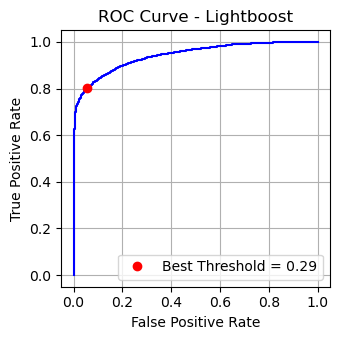

In [452]:
lgbc = LGBMClassifier(
        n_estimators=310,
        max_depth=3,
        learning_rate=0.2407876672736751,
        num_leaves=159,
        subsample=0.8387855528215907,
        colsample_bytree=0.9669706501866624,
        min_child_samples=85,
        reg_alpha=0.7125900911615434,
        reg_lambda=3.7587526456594036,
        n_jobs=-1,
        random_state=42,verbose=-1
    )
report(lgbc,name="Lightboost")

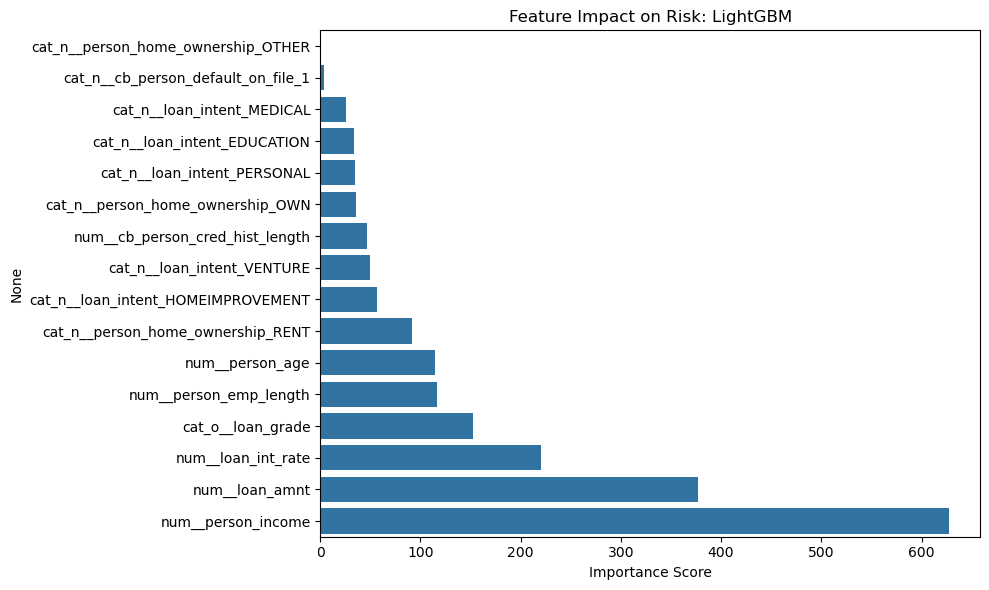

In [453]:
plot_feature_importances(lgbc.feature_importances_,"LightGBM")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">Catboost</h1>

In [455]:
"""def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 500),
        depth=trial.suggest_int("depth", 4, 10),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        border_count=trial.suggest_int("border_count", 32, 255),
        random_strength=trial.suggest_float("random_strength", 0.1, 10.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 1.0),
        od_type="Iter",
        verbose=0,
        task_type="CPU",
        thread_count=-1,
        random_state=42
    )

    auc_scores = []
    accuracy_diff_ok = True
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        clf = clone(model)
        clf.fit(X_tr, y_tr)

        y_val_proba = clf.predict_proba(X_val)[:, 1]
        y_val_pred = clf.predict(X_val)
        y_train_pred = clf.predict(X_tr)

        auc = roc_auc_score(y_val, y_val_proba)
        auc_scores.append(auc)

        train_acc = accuracy_score(y_tr, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        if train_acc - val_acc > 0.012:
            accuracy_diff_ok = False
            break

    return np.mean(auc_scores) if accuracy_diff_ok else 0.0

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300, n_jobs=-1)

# Show results
print("Best AUC:", study.best_value)
print("Best Parameters:")
print(study.best_params)"""


'def objective(trial):\n    model = CatBoostClassifier(\n        iterations=trial.suggest_int("iterations", 100, 500),\n        depth=trial.suggest_int("depth", 4, 10),\n        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3, log=True),\n        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1.0, 10.0),\n        border_count=trial.suggest_int("border_count", 32, 255),\n        random_strength=trial.suggest_float("random_strength", 0.1, 10.0),\n        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 1.0),\n        od_type="Iter",\n        verbose=0,\n        task_type="CPU",\n        thread_count=-1,\n        random_state=42\n    )\n\n    auc_scores = []\n    accuracy_diff_ok = True\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n    for train_idx, val_idx in skf.split(X_train, y_train):\n        X_tr, X_val = X_train[train_idx], X_train[val_idx]\n        y_tr, y_val = y_train[train_idx], y_train[val_idx]\n\n        clf = clone(

TEST RESULTS

AUC : 0.936512
F1 : 0.828444
Recall : 0.736395
Precision : 0.946793
Accuracy : 0.933605
[Training accuracy: 0.936641]

     0       1
0    6266    73
1    465    1299




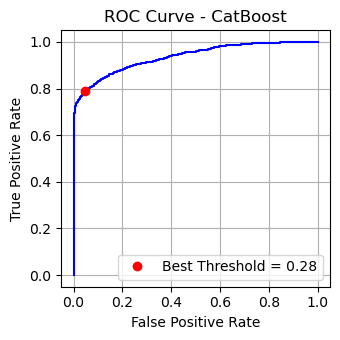

In [456]:
ctbc = CatBoostClassifier(
        iterations=190,
        depth=7,
        learning_rate=0.29719417590886094,
        l2_leaf_reg=8.951163270964644,
        border_count=240,
        random_strength=8.653967636575747,
        bagging_temperature=0.9988816285851313,
        od_type="Iter",
        verbose=0,
        task_type="CPU",
        thread_count=-1,
        random_state=42
    )
report(ctbc,name="CatBoost")

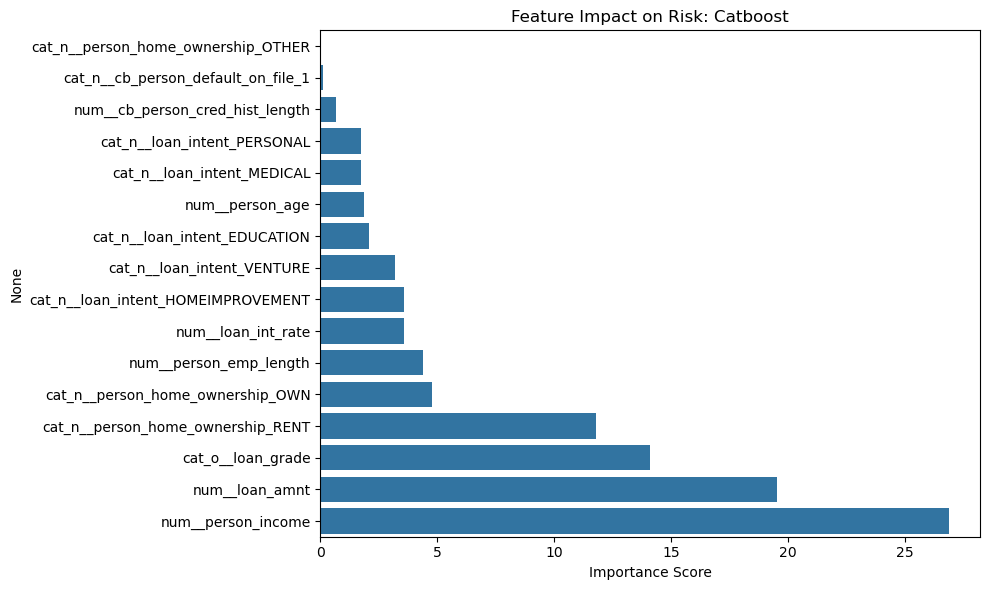

In [457]:
plot_feature_importances(ctbc.get_feature_importance(),"Catboost")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">Multi Layer Perceptron</h1>

In [459]:
"""def objective(trial):
    hidden_layer_sizes = tuple([
        trial.suggest_int("layer_1", 32, 256),
        trial.suggest_int("layer_2", 16, 128),
        trial.suggest_categorical("layer_3", [0, 32, 64])  # optional 3rd layer
    ])
    hidden_layer_sizes = tuple([h for h in hidden_layer_sizes if h > 0])

    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=trial.suggest_categorical("activation", ["relu", "tanh"]),
        solver=trial.suggest_categorical("solver", ["adam", "lbfgs"]),
        alpha=trial.suggest_float("alpha", 1e-5, 1e-2, log=True),
        learning_rate_init=trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True),
        max_iter=300,
        early_stopping=True,
        random_state=42
    )

    auc_scores = []
    accuracy_diff_ok = True
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        clf = clone(model)
        clf.fit(X_tr, y_tr)

        y_val_proba = clf.predict_proba(X_val)[:, 1]
        y_val_pred = clf.predict(X_val)
        y_train_pred = clf.predict(X_tr)

        auc = roc_auc_score(y_val, y_val_proba)
        auc_scores.append(auc)

        train_acc = accuracy_score(y_tr, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        if train_acc - val_acc > 0.012:
            accuracy_diff_ok = False
            break

    return np.mean(auc_scores) if accuracy_diff_ok else 0.0

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

# Show best results
print("Best AUC:", study.best_value)
print("Best parameters:")
print(study.best_params)"""


'def objective(trial):\n    hidden_layer_sizes = tuple([\n        trial.suggest_int("layer_1", 32, 256),\n        trial.suggest_int("layer_2", 16, 128),\n        trial.suggest_categorical("layer_3", [0, 32, 64])  # optional 3rd layer\n    ])\n    hidden_layer_sizes = tuple([h for h in hidden_layer_sizes if h > 0])\n\n    model = MLPClassifier(\n        hidden_layer_sizes=hidden_layer_sizes,\n        activation=trial.suggest_categorical("activation", ["relu", "tanh"]),\n        solver=trial.suggest_categorical("solver", ["adam", "lbfgs"]),\n        alpha=trial.suggest_float("alpha", 1e-5, 1e-2, log=True),\n        learning_rate_init=trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True),\n        max_iter=300,\n        early_stopping=True,\n        random_state=42\n    )\n\n    auc_scores = []\n    accuracy_diff_ok = True\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n    for train_idx, val_idx in skf.split(X_train, y_train):\n        X_tr, X_val = X_t

TEST RESULTS



C:\Users\shaur\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC : 0.914240
F1 : 0.791667
Recall : 0.721655
Precision : 0.876722
Accuracy : 0.917315
[Training accuracy: 0.940509]

     0       1
0    6160    179
1    491    1273




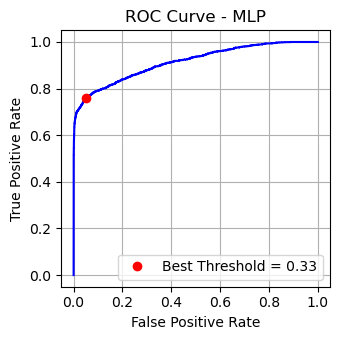

In [460]:
#takes 2 minutes
mlp = MLPClassifier(
    hidden_layer_sizes=(239,59,32),
    activation='tanh',
    solver='adam',
    alpha=0.009932173182688624,
    learning_rate_init=0.0005454122953245967,
    random_state=42
)
report(mlp,name="MLP")

<h1 style="font-size:30px; color:cyan; font-weight:bold;">Model Selection</h1>

In [462]:
results.sort_values(by='AUC',ascending=False).reset_index(drop=True)           

,model_name,AUC,F1,Recall,Precision,Accuracy
0,XGBoost,0.943860,0.835726,0.74263,0.955507,0.936443
1,Lightboost,0.942804,0.818326,0.729025,0.93256,0.929532
2,Adaboost,0.941156,0.819308,0.731293,0.931408,0.929779
3,CatBoost,0.936512,0.828444,0.736395,0.946793,0.933605
4,Random Forest,0.934175,0.807856,0.699546,0.955848,0.927558
5,Voting,0.930215,0.806598,0.706916,0.939006,0.9262
6,Gradient Boosting,0.926805,0.80896,0.716553,0.928729,0.926324
7,MLP,0.914240,0.791667,0.721655,0.876722,0.917315
8,Decision Tree,0.903693,0.751973,0.756236,0.747758,0.891398
9,Bagging,0.902824,0.514519,0.356576,0.923642,0.853511


<div style="border: 1px solid black; padding: 5px; background-color: white; color: black; font-size: 16px; font-weight: bold; text-align: left;">
📌 <em>So the best performing model is XGBOOST with the tuned parameters</em>

</div>

In [464]:
feature_importances_df 

,num__person_age,num__person_income,num__person_emp_length,num__loan_amnt,num__loan_int_rate,num__cb_person_cred_hist_length,cat_o__loan_grade,cat_n__person_home_ownership_OTHER,cat_n__person_home_ownership_OWN,cat_n__person_home_ownership_RENT,cat_n__loan_intent_EDUCATION,cat_n__loan_intent_HOMEIMPROVEMENT,cat_n__loan_intent_MEDICAL,cat_n__loan_intent_PERSONAL,cat_n__loan_intent_VENTURE,cat_n__cb_person_default_on_file_1
Linear Regression,-0.035332,-1.824946,-0.005375,0.700520,-0.077426,-0.009612,-0.881748,0.611663,-1.181863,0.785387,-0.736973,0.090442,-0.214862,-0.546488,-0.957553,-0.140765
SVC,-0.045434,-1.312498,0.006680,0.530584,-0.223471,-0.002925,-0.750074,0.637903,-0.745905,0.543392,-0.521855,0.087898,-0.150675,-0.385612,-0.540940,-0.169140
Adaboost,0.047050,0.289088,0.042140,0.161077,0.053499,0.015319,0.131346,0.001708,0.075052,0.091634,0.008563,0.017928,0.023847,0.008952,0.031381,0.001415
Decision Tree,0.012635,0.306679,0.015661,0.157799,0.013919,0.003197,0.280624,0.000000,0.032789,0.106024,0.007152,0.026024,0.012695,0.007528,0.015929,0.001345
Gradient Boosting,0.012408,0.287186,0.037225,0.168297,0.103060,0.002232,0.166811,0.000694,0.025599,0.095117,0.017806,0.026788,0.021348,0.013470,0.017229,0.004729
Random Forest,0.020367,0.282258,0.056592,0.170372,0.035920,0.011825,0.195895,0.000000,0.026742,0.103915,0.008710,0.029664,0.025145,0.011217,0.019204,0.002175
XGBoost,0.017172,0.064970,0.029954,0.059497,0.025605,0.011080,0.314239,0.008993,0.062834,0.129016,0.037491,0.066610,0.053557,0.049815,0.040692,0.028476
LightGBM,114.000000,627.000000,116.000000,377.000000,220.000000,47.000000,152.000000,0.000000,36.000000,92.000000,34.000000,57.000000,26.000000,35.000000,50.000000,4.000000
Catboost,1.856833,26.854382,4.406656,19.504200,3.571362,0.673769,14.086765,0.025878,4.790616,11.795055,2.079851,3.565768,1.739388,1.732655,3.189435,0.127388


In [465]:
feature_importances_df

,num__person_age,num__person_income,num__person_emp_length,num__loan_amnt,num__loan_int_rate,num__cb_person_cred_hist_length,cat_o__loan_grade,cat_n__person_home_ownership_OTHER,cat_n__person_home_ownership_OWN,cat_n__person_home_ownership_RENT,cat_n__loan_intent_EDUCATION,cat_n__loan_intent_HOMEIMPROVEMENT,cat_n__loan_intent_MEDICAL,cat_n__loan_intent_PERSONAL,cat_n__loan_intent_VENTURE,cat_n__cb_person_default_on_file_1
Linear Regression,-0.035332,-1.824946,-0.005375,0.700520,-0.077426,-0.009612,-0.881748,0.611663,-1.181863,0.785387,-0.736973,0.090442,-0.214862,-0.546488,-0.957553,-0.140765
SVC,-0.045434,-1.312498,0.006680,0.530584,-0.223471,-0.002925,-0.750074,0.637903,-0.745905,0.543392,-0.521855,0.087898,-0.150675,-0.385612,-0.540940,-0.169140
Adaboost,0.047050,0.289088,0.042140,0.161077,0.053499,0.015319,0.131346,0.001708,0.075052,0.091634,0.008563,0.017928,0.023847,0.008952,0.031381,0.001415
Decision Tree,0.012635,0.306679,0.015661,0.157799,0.013919,0.003197,0.280624,0.000000,0.032789,0.106024,0.007152,0.026024,0.012695,0.007528,0.015929,0.001345
Gradient Boosting,0.012408,0.287186,0.037225,0.168297,0.103060,0.002232,0.166811,0.000694,0.025599,0.095117,0.017806,0.026788,0.021348,0.013470,0.017229,0.004729
Random Forest,0.020367,0.282258,0.056592,0.170372,0.035920,0.011825,0.195895,0.000000,0.026742,0.103915,0.008710,0.029664,0.025145,0.011217,0.019204,0.002175
XGBoost,0.017172,0.064970,0.029954,0.059497,0.025605,0.011080,0.314239,0.008993,0.062834,0.129016,0.037491,0.066610,0.053557,0.049815,0.040692,0.028476
LightGBM,114.000000,627.000000,116.000000,377.000000,220.000000,47.000000,152.000000,0.000000,36.000000,92.000000,34.000000,57.000000,26.000000,35.000000,50.000000,4.000000
Catboost,1.856833,26.854382,4.406656,19.504200,3.571362,0.673769,14.086765,0.025878,4.790616,11.795055,2.079851,3.565768,1.739388,1.732655,3.189435,0.127388


In [466]:
#now we will scale each row such that sum of each feature importance(magnitude) is 100. so we get percentages for each feature and sign is also
#preserved
def scale_row(row):
    sum_row = row.abs().sum()
    return 100*row/sum_row
scaled_importances= feature_importances_df.apply(scale_row,axis=1)

In [467]:
scaled_importances

,num__person_age,num__person_income,num__person_emp_length,num__loan_amnt,num__loan_int_rate,num__cb_person_cred_hist_length,cat_o__loan_grade,cat_n__person_home_ownership_OTHER,cat_n__person_home_ownership_OWN,cat_n__person_home_ownership_RENT,cat_n__loan_intent_EDUCATION,cat_n__loan_intent_HOMEIMPROVEMENT,cat_n__loan_intent_MEDICAL,cat_n__loan_intent_PERSONAL,cat_n__loan_intent_VENTURE,cat_n__cb_person_default_on_file_1
Linear Regression,-0.401462,-20.735771,-0.061068,7.959594,-0.879749,-0.109214,-10.018774,6.949960,-13.428799,8.923888,-8.373779,1.027633,-2.441352,-6.209422,-10.880103,-1.599433
SVC,-0.682703,-19.722035,0.100381,7.972730,-3.357949,-0.043947,-11.270865,9.585335,-11.208214,8.165184,-7.841567,1.320780,-2.264086,-5.794337,-8.128339,-2.541548
Adaboost,4.704984,28.908814,4.214000,16.107741,5.349920,1.531916,13.134573,0.170838,7.505176,9.163422,0.856268,1.792804,2.384669,0.895194,3.138147,0.141534
Decision Tree,1.263507,30.667902,1.566079,15.779854,1.391905,0.319676,28.062372,0.000000,3.278942,10.602362,0.715226,2.602441,1.269544,0.752804,1.592875,0.134511
Gradient Boosting,1.240810,28.718606,3.722535,16.829678,10.306040,0.223231,16.681088,0.069415,2.559916,9.511676,1.780595,2.678815,2.134756,1.347000,1.722890,0.472949
Random Forest,2.036697,28.225844,5.659208,17.037183,3.591970,1.182517,19.589459,0.000000,2.674162,10.391467,0.870987,2.966422,2.514518,1.121663,1.920419,0.217484
XGBoost,1.717179,6.496986,2.995448,5.949654,2.560462,1.107981,31.423939,0.899256,6.283398,12.901639,3.749054,6.661041,5.355670,4.981498,4.069168,2.847629
LightGBM,5.737292,31.555108,5.837947,18.973327,11.071968,2.365375,7.649723,0.000000,1.811777,4.630096,1.711122,2.868646,1.308505,1.761449,2.516356,0.201309
Catboost,1.856833,26.854382,4.406656,19.504200,3.571362,0.673769,14.086765,0.025878,4.790616,11.795055,2.079851,3.565768,1.739388,1.732655,3.189435,0.127388


<div style="border: 1px solid black; padding: 5px; background-color: white; color: black; font-size: 16px; font-weight: bold; text-align: left;">
📌 <em>So, for conclusion the linear models Logistic and SVC suggest that the most prominent:<br><br>
1.Highly RISK INCREASING FEATURES ARE: <br>
->Higher Loan Amount<br>
->If a person owns a 'RENTED' or 'OTHER category' home<br><br>

2.RISK DECREASING FEATURES ARE: <br>
->Higher the person's income<br>
->Loan Grade<br>
->If a person owns their home<br>
->If loan intent is Education,Personal or Venture

OVERALL IMPORTANT FEATURES THAT REDUCE ERROR A/C TO TREE BASED MODELS ARE: <br>
->the person's income<br>
->Loan Amount<br>
->Load grade category<br>
->If home ownership is rent<br>
</em>


</div>

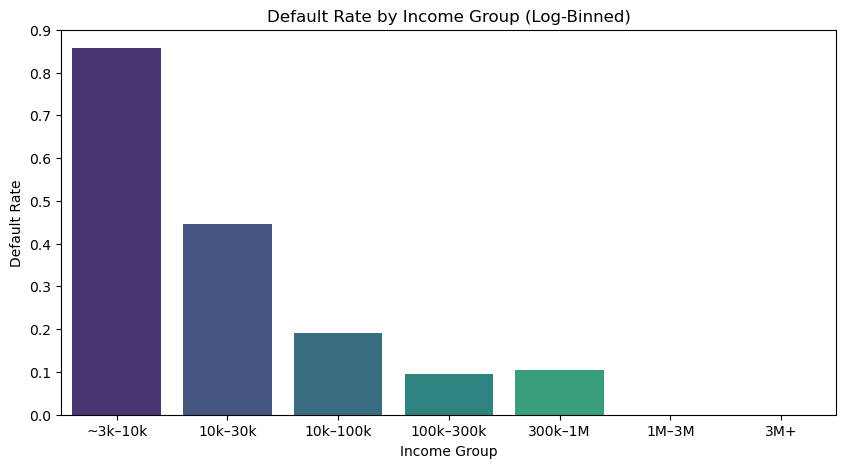

In [469]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

income_risk_df = pd.DataFrame({
    'person_income': X['person_income'],
    'default': y
})

income_risk_df['income_bin'] = pd.cut(
    np.log10(income_risk_df['person_income']),
    bins=[3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7],
    labels=['~3k–10k', '10k–30k', '10k–100k', '100k–300k', '300k–1M', '1M–3M', '3M+']
)

grouped = income_risk_df.groupby('income_bin', observed=False)['default'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=grouped, x='income_bin', y='default', hue='income_bin', palette='viridis', legend=False)
plt.title('Default Rate by Income Group (Log-Binned)')
plt.xlabel('Income Group')
plt.ylabel('Default Rate')
plt.show()


In [ ]:
"""
CONCLUSIONS
1. ONE OF THE MOST IMPORTANT THING WAS TO CREATE A PIPELINE THAT ENCODES CATEGORICAL COLUMNS, IMPUTES MISSING VALUES AND SCALES THE NUMERICAL COLUMNS
2. CLASS IMBALANCE (79% VS 21%) WAS HANDLED BY USING
    a> manual and automatic class_weight assignment during fitting of models
    b> using stratified k fold cv
3. Multiple models were tested for variety including ensemble models like voting and bagging
4. Since accuracy is not much of use in case of data imbalance, AUC score and F1 score was given importance
5. If there was collinearity, it was chosen not to remove or combine those columns for sake of model interpretability.
6.features like person_income and loan_amnt are strong indicators of a borrower’s financial behavior and history. 

what could be done better: the importance of feature cb_person_default_on_file  was lower, which does not correlate to the real world, where credit history 
is very important to determine risk.
Business understanding: Credit Institutions can pick and choose a model according to their preferred RECALL and PRECISION.
HIGH RECALL ensures aggressive identifying of potential defaulters but can punish safe borrowers, risking reputation and lending model of bank
HIGH PRECISION ensures less creditworthy applicants are rejected, but can risk more potential defaulters getting through.
Financial Institutions can fine tune these metrics to suit their needs."""